In [46]:
%matplotlib inline


Differential Temperature Advection with NARR Data
=================================================

By: Kevin Goebbert

This example creates a four-panel plot to illustrate the difference
between single level temperature advection and a computed differential
temperature advection between two layers. This example makes use of NARR
output.


In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

In [48]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [49]:
startYear = 2011
startMonth = 4
startDay = 26
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2011
endMonth = 4
endDay = 29
endHour = 0
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


In [50]:
dsZ = xr.open_dataset ('/cfsr/data/%s/g.%s.0p5.anl.nc' % (startYear, startYear))
dsT = xr.open_dataset ('/cfsr/data/%s/t.%s.0p5.anl.nc' % (startYear, startYear))
dsU = xr.open_dataset ('/cfsr/data/%s/u.%s.0p5.anl.nc' % (startYear, startYear))
dsV = xr.open_dataset ('/cfsr/data/%s/v.%s.0p5.anl.nc' % (startYear, startYear))
dsW = xr.open_dataset ('/cfsr/data/%s/w.%s.0p5.anl.nc' % (startYear, startYear))
dsQ = xr.open_dataset ('/cfsr/data/%s/q.%s.0p5.anl.nc' % (startYear, startYear))
dsSLP = xr.open_dataset ('/cfsr/data/%s/pmsl.%s.0p5.anl.nc' % (startYear, startYear))

In [51]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['2011-04-26 00:00:00', '2011-04-26 06:00:00',
               '2011-04-26 12:00:00', '2011-04-26 18:00:00',
               '2011-04-27 00:00:00', '2011-04-27 06:00:00',
               '2011-04-27 12:00:00', '2011-04-27 18:00:00',
               '2011-04-28 00:00:00', '2011-04-28 06:00:00',
               '2011-04-28 12:00:00', '2011-04-28 18:00:00',
               '2011-04-29 00:00:00'],
              dtype='datetime64[ns]', freq='6H')

In [52]:
lonW = -125
lonE = -65
latS = 25
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

Data Input
----------

Use Xarray to access GFS data from THREDDS resource and uses
metpy accessor to parse file to make it easy to pull data using
common coordinate names (e.g., vertical) and attach units.




In [53]:


# Calculate variable dx, dy values for use in calculations
dx, dy = mpcalc.lat_lon_grid_deltas(lats, lons)

# Get 700-hPa data and smooth
level = 700 * units.hPa
hght_700 = mpcalc.smooth_n_point(ds['Geopotential_height_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
tmpk_700 = mpcalc.smooth_n_point(ds['Temperature_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
uwnd_700 = mpcalc.smooth_n_point(
    ds['u-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)
vwnd_700 = mpcalc.smooth_n_point(
    ds['v-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)

# Get 300-hPa data and
level = 300 * units.hPa
hght_300 = mpcalc.smooth_n_point(ds['Geopotential_height_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
tmpk_300 = mpcalc.smooth_n_point(ds['Temperature_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
uwnd_300 = mpcalc.smooth_n_point(
    ds['u-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)
vwnd_300 = mpcalc.smooth_n_point(
    ds['v-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)

# Convert Temperatures to degC
tmpc_700 = tmpk_700.metpy.convert_units('degC')
tmpc_300 = tmpk_300.metpy.convert_units('degC')

# Get time in a nice datetime object format
vtime = ds.time.values.astype('datetime64[ms]').astype('O')[0]

Differential Temperature Advection Calculation
----------------------------------------------

Use MetPy advection funtion to calculate temperature advection at 700
and 300 hPa, then manually compute the differential between those two
layers. The differential temperature advection is then valid at 500 hPa
(due to centered differencing) and is the same level that height changes
due to absolute vorticity advection is commonly assessed.




In [54]:
# Use MetPy advection function to calculate temperature advection at two levels
tadv_700 = mpcalc.advection(tmpk_700, uwnd_700, vwnd_700)
tadv_300 = mpcalc.advection(tmpk_300, uwnd_300, vwnd_300)

# Centered finite difference to calculate differential temperature advection
diff_tadv = tadv_300 - tadv_700

/tmp/ipykernel_101633/3840734029.py:2: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  tadv_700 = mpcalc.advection(tmpk_700, uwnd_700, vwnd_700)
/tmp/ipykernel_101633/3840734029.py:2: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  tadv_700 = mpcalc.advection(tmpk_700, uwnd_700, vwnd_700)
/tmp/ipykernel_101633/3840734029.py:3: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  tadv_300 = mpcalc.advection(tmpk_300, uwnd_300, vwnd_300)
/tmp/ipykernel_101633/3840734029.py:3: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  tadv_300 = mpcalc.advection(tmpk_300, uwnd_300, vwnd_300)


In [55]:
diff_tadv

Magnitude,[[-4.087678462383337e-05 -2.0910612875013612e-05 2.8907128580613062e-05 ... 1.6200665413634852e-06 4.359044396551326e-06 8.906690709409304e-07] [-3.157281025778502e-05 -1.0308422133675776e-05 1.6636422515148297e-05 ... -2.3060356397763826e-06 -2.398737706243992e-06 -4.443868419912178e-06] [-1.3810045857098885e-05 -8.314127626363188e-07 1.3557008060161024e-05 ... -5.775327736046165e-06 -6.047875103831757e-06 -7.926791113277432e-06] ... [-6.969775131437927e-05 -6.749402382411063e-05 -6.287122960202396e-05 ... -4.1951192542910576e-05 -3.2946685678325593e-05 -2.0853778551099822e-05] [-6.353786011459306e-05 -6.160687189549208e-05 -5.7739100157050416e-05 ... -5.7296419981867075e-06 4.985442501492798e-06 1.5909528883639723e-05] [-6.860950088594109e-05 -5.5400967539753765e-05 -5.498711107065901e-05 ... 3.901949094142765e-05 4.070410068379715e-05 2.8823087632190436e-05]]
Units,kelvin/second


Make Four Panel Plot
--------------------

A four panel plot is produced to illustrate the temperature fields at
two levels (700 and 300 hPa), which are common fields to be plotted.
Then a panel containing the evaluated temperature advection at 700 hPa
and differential temperature advection between 700 and 300 hPa. Of
meteorological significance is the difference between these two
advection plots. For the QG Height Tendency equation, the forcing term
is proportional to the differential temperature advection, which paints
a slightly different picture than just the 700-hPa temperature advection
alone.

To create the four panel plot it takes a bit of code at this point. The
following code is segmented into Upper-left, Lower-left, Upper-right,
Lower-right panels using matplotlib’s gridspec to help with spacing.




In [56]:
lonW = -135
lonE = -55
latS = 15
latN = 58
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2

expand = 0.5
latRange = np.arange(latS,latN + expand, .5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE + expand, .5)

proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

In [57]:
diff_tadv.min(), diff_tadv.max()

(<xarray.DataArray ()>
 <Quantity(-0.0017158199334517121, 'kelvin / second')>
 Coordinates:
     time       datetime64[ns] 1993-03-13T18:00:00
     metpy_crs  object Projection: lambert_conformal_conic,
 <xarray.DataArray ()>
 <Quantity(0.001988979522138834, 'kelvin / second')>
 Coordinates:
     time       datetime64[ns] 1993-03-13T18:00:00
     metpy_crs  object Projection: lambert_conformal_conic)

In [58]:
maxAdv = .001
minAdv = -.001
stepAdv = .0001

intervals = np.arange(minAdv, maxAdv, stepAdv)
intervals

array([-1.00000000e-03, -9.00000000e-04, -8.00000000e-04, -7.00000000e-04,
       -6.00000000e-04, -5.00000000e-04, -4.00000000e-04, -3.00000000e-04,
       -2.00000000e-04, -1.00000000e-04,  4.33680869e-19,  1.00000000e-04,
        2.00000000e-04,  3.00000000e-04,  4.00000000e-04,  5.00000000e-04,
        6.00000000e-04,  7.00000000e-04,  8.00000000e-04,  9.00000000e-04])

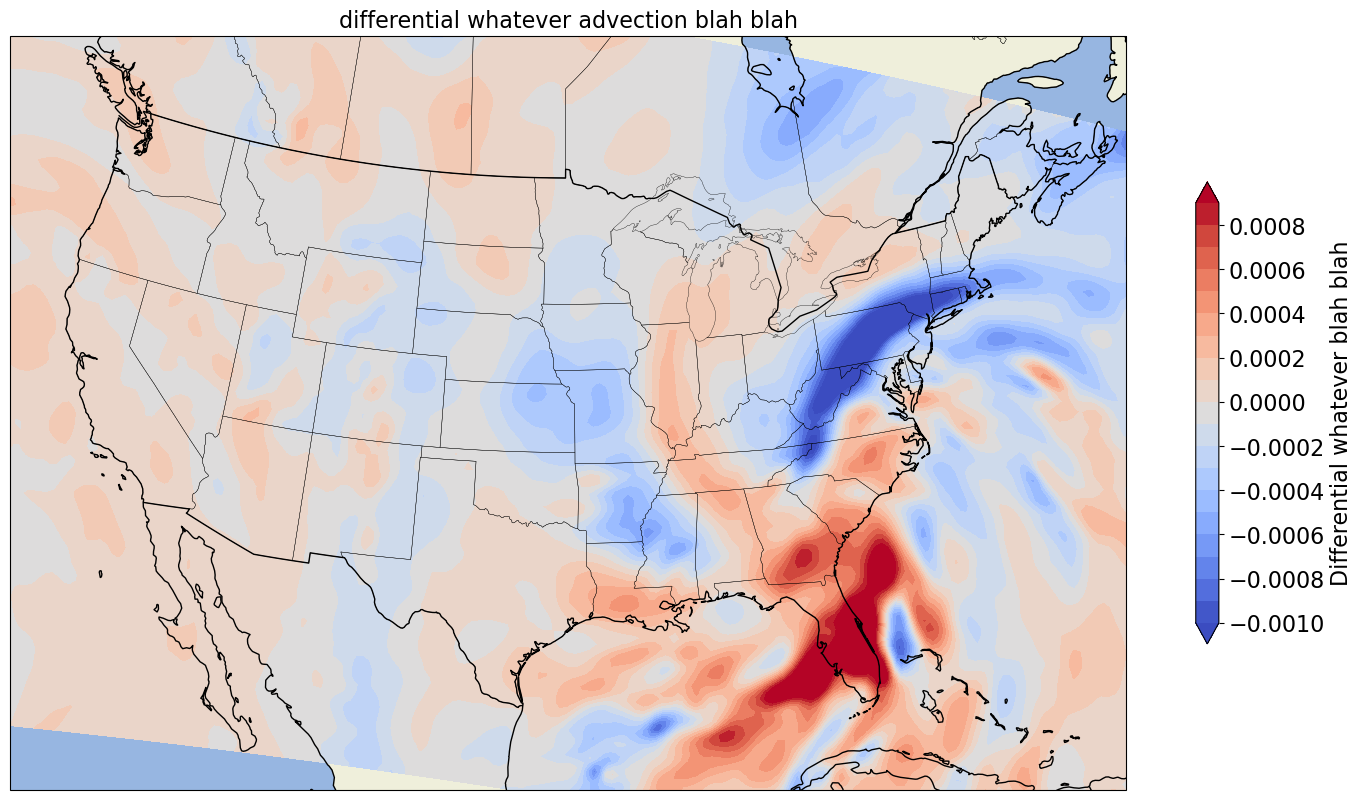

In [59]:
constrainLon = 15 # trial and error!
constrainLat = 5

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.BORDERS.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res),linewidth=0.25)
ax.add_feature(cfeature.LAND.with_scale(res))

CF = ax.contourf(lons, lats, diff_tadv, levels=intervals, transform=proj_data, cmap='coolwarm', extend='both', zorder=0)
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Differential whatever blah blah",fontsize=16)

title = plt.title("differential whatever advection blah blah",fontsize=16)